In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms



In [2]:
class Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self, feature_maps, dropouts):
        super(Classifier, self).__init__()
        self.feature_maps = feature_maps
        self.dropouts = dropouts
        layers = self.layer(1,feature_maps[0], dropouts[0])+self.layer(feature_maps[0],feature_maps[1], dropouts[1])+self.layer(feature_maps[1],feature_maps[2], dropouts[2])+self.layer(feature_maps[2],feature_maps[3], dropouts[3])+self.layer(feature_maps[3],feature_maps[4], dropouts[4])
        self.conv = nn.Sequential(*layers)
        self.clf = nn.Linear(feature_maps[-1], 10)
        self.drop = nn.Dropout(p=0.4)
        
        
        
    def layer(self, i, o, dropout=0.1):
        return [nn.Conv2d(in_channels=i, out_channels=o, kernel_size=(4, 4), padding=2),
                nn.Dropout(p=dropout),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2), stride=2)]
    
    def num_parameters(self):
        pars = 0
        for a,b in zip([1] + self.feature_maps, self.feature_maps):
            current_layer_parameters = a * 16 * b
            pars = pars + current_layer_parameters
        pars = pars + self.feature_maps[-1] * 10
        print("we have ", float(pars)/1000000, " million parameters") # Ignore biases
    
    def forward(self, x):
        x = self.conv(x)
        y = x.squeeze()
        return self.clf(self.drop(y))

In [3]:
import pprint

perf = {}

torch.manual_seed(0)
mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transforms, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=mnist_transforms, download=True)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True, num_workers=2)

cuda_available = torch.cuda.is_available()
print("Cuda available: %s" % cuda_available)
feature_maps = [[20,40,60,80,128], [20,40,60,50,40], [20,40,50,60,70]]
dropouts = [[0, 0.1, 0.1, 0.1,0.1 ], [0, 0.4, 0.4, 0.1,0.1 ], [0, 0.1, 0.5, 0.1,0.5 ]]
feature_maps = [feature_maps[0]]
dropouts = [dropouts[0]]

for feature_map in feature_maps:
    for dropout in dropouts:
        hyper = str(feature_map)+" "+str(dropout)
        print(hyper)
        perf[hyper] = []
        clf = Classifier(feature_map, dropout)
        clf.num_parameters()
        if cuda_available:
            clf = clf.cuda()
        optimizer = torch.optim.Adam(clf.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss() #  LogSoftmax and NLLLoss

        for epoch in range(10):
            # Train
            current_epoch_loss = []
            for batch_idx, (inputs, targets) in enumerate(train_loader):
                if cuda_available:
                    inputs, targets = inputs.cuda(), targets.cuda()

                optimizer.zero_grad()
                loss = criterion(clf(inputs), targets)
                loss.backward()
                optimizer.step()
                current_epoch_loss.append(loss.item())
            myLoss =  np.mean(current_epoch_loss)
            
            #    if batch_idx%500==0:
            #       print('Epoch : %d, Loss : %.3f ' % (epoch, np.mean(losses)))
            
            # Evaluate
            clf.eval()
            total = 0
            correct = 0
            for batch_idx, (inputs, targets) in enumerate(test_loader):
                if cuda_available:
                    inputs, targets = inputs.cuda(), targets.cuda()
                outputs = clf(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += predicted.eq(targets.data).cpu().sum()
            accur = 100*float(correct)/total    
            #print('Epoch : %d, Test Accuracy : %.2f%%, number of tests : %d' % (epoch, accur, total))
            #print('--------------------------------------------------------------')
            clf.train()
            perf[hyper].append((accur, myLoss))
        print(perf[hyper])



Cuda available: True
[20, 40, 60, 80, 128] [0, 0.1, 0.1, 0.1, 0.1]
we have  0.29344  million parameters
[(97.73, 0.3133403287211588), (98.56, 0.07701171177830587), (99.05, 0.05405241299643001), (99.23, 0.04303718856903218), (99.12, 0.03510017940865905), (99.15, 0.03182496242066309), (99.24, 0.027519334534576327), (99.12, 0.0239454806784291), (99.15, 0.022417329283538404), (99.2, 0.020359554862194477)]


# we select the  top 3 combination of hyperparameters in the following:  

In [5]:
def plotThis(x, label ):
    xnew = np.linspace(np.arange(x.shape[0]).min(),np.arange(x.shape[0]).max(),300)
    spl = make_interp_spline(np.arange(x.shape[0]),x, k=3)
    power_smooth = spl(xnew)
    xx = plt.plot(xnew,power_smooth, label = label)


In [6]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline


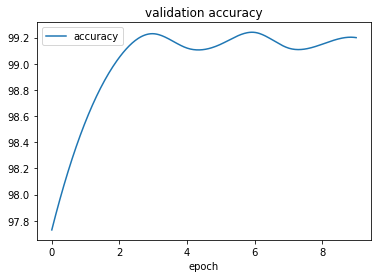

In [14]:
plotThis(np.array([x[0] for x in perf["[20, 40, 60, 80, 128] [0, 0.1, 0.1, 0.1, 0.1]"]]), "accuracy")

plt.title("validation accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [9]:
perf["[20, 40, 60, 80, 128] [0, 0.1, 0.1, 0.1, 0.1]"][0]

(97.73, 0.3133403287211588)

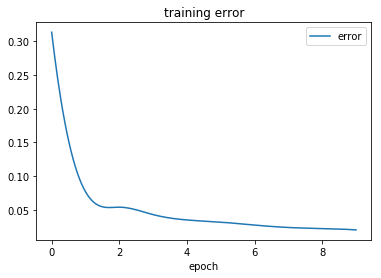

In [13]:
plotThis(np.array([x[1] for x in perf["[20, 40, 60, 80, 128] [0, 0.1, 0.1, 0.1, 0.1]"]]), "error")

plt.title("training error")
plt.legend()
plt.xlabel("epoch")
plt.show()